In [1]:
from Bio import Entrez
Entrez.email = 'shl198@eng.ucsd.edu'
import re,os,sarge
import pandas as pd
from natsort import natsorted
from Bio import SeqIO
from IPython.display import Markdown
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use('ggplot')
# import seaborn

In [2]:
thread = 9
#----------------- PASA related parameter ----------------
pasa = '/home/shangzhong/Installation/PASApipeline-2.0.2'
ppl_fn = pasa + '/scripts/Launch_PASA_pipeline.pl'
config = pasa + '/pasa_conf/pasa.alignAssembly.Template.txt'
db = 'picr_db_stringtie'
#----------------- transdecoder related parameter --------
transde_code_path = '/home/shangzhong/Installation/TransDecoder-v5.0.2'
#----------------- Annotation related parameter ----------
path = '/data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie'
hamster_id = '/data/shangzhong/Database/hamster/hamster_all_id.txt'
ref_fa = '/data/genome/hamster/picr_old/picr.fa'
rna_fa = path + '/hamster_rna.fa'
pr_fa  = path + '/hamster_pr.fa'
uniprot_fa = path + '/uniprot_sprot.fasta'
stringtie_gtf = path + '/stringtie_merge.gtf'

#----------------- Don't need to change the following parameter --------------
trans2hamster = path + '/map2hamster.txt'
trans2uniprot = path + '/map2uniprot.txt'
pasa2hamrna = path + '/map2hamrna.txt'

#### 1. Merge stringtie gff and gmap mapping results using PASA
Results are saved in folder pasa_assem. There are 3 important files from pasa:
1. file.pasa_assemblies.gff3: has rna map positions
2. file.pasa_assembies_described.txt: has clusters of rnas.
3. file.assemblies.fasta: has sequence of rna

In [3]:
def align_assemble(ppl_fn,config,ref_fa,rna_fa,thread,stringtie_gtf,otherParameters=['']):
    '''This function do alignment assembly
    generate 4 type of files: 
    sample_mydb_pasa.assemblies.fasta :the PASA assemblies in FASTA format.
    sample_mydb_pasa.pasa_assemblies.gff3,.gtf,.bed :the PASA assembly structures.
    sample_mydb_pasa.pasa_alignment_assembly_building.ascii_illustrations.out :descriptions 
        of alignment assemblies and how they were constructed from the underlying transcript alignments.
    sample_mydb_pasa.pasa_assemblies_described.txt :tab-delimited format describing the contents
         of the PASA assemblies, including the identity of those transcripts that were assembled into the corresponding structure.
    '''
    cmd = ('{ppl} -c {config} -C -r -R -g {ref_fa} --cufflinks_gtf {stringtie}\
             -t {rna_fa} --ALIGNERS gmap --CPU {thread} {other} ').format(ppl=ppl_fn,config=config,
            ref_fa=ref_fa,stringtie=stringtie_gtf,rna_fa=rna_fa,thread=str(thread),other=' '.join(otherParameters))
    sarge.run(cmd)

In [4]:
pasa_res_path = path + '/pasa_assem'
pasa_gff = pasa_res_path + '/' + db + '.pasa_assemblies.gff3'
pasa_desp = pasa_res_path + '/' + db + '.pasa_assemblies_described.txt'
pasa_assm = pasa_res_path + '/' + db + '.assemblies.fasta'
os.chdir(pasa_res_path)
if not os.path.exists(pasa_gff):
    align_assemble(ppl_fn,config,ref_fa,rna_fa,thread,stringtie_gtf,otherParameters=[''])

#### Predict proteins in PASA assemblies using transdecoder
Files that are important: 
1. file.assemblies.fasta.transdecoder.pep: has predicted peptides
2. file.transdecoder.genome.gff3: predicted protein annotation

In [5]:
transde_path = path + '/transdecoder'
if not os.path.exists(transde_path): os.mkdir(transde_path)
os.chdir(transde_path)
# transde_gff = transde_path + '/' + db + '.assemblies.fasta.transdecoder.gff3'
transde_pep = transde_path + '/' + db + '.assemblies.fasta.transdecoder.pep'
trans_gene_gff = transde_path + '/' + db + '.transdecoder.genome.gff3'
# get ORF longer than 100 AA
if not os.path.exists(trans_gene_gff):
    cmd = ('{trans} -t {rna_fa}').format(trans=transde_code_path+'/TransDecoder.LongOrfs',rna_fa=pasa_assm)
    sarge.run(cmd)
    cmd = ('{trans} -t {rna_fa}').format(trans=transde_code_path+'/TransDecoder.Predict',rna_fa=pasa_assm)
    sarge.run(cmd)
    cmd = ('{orf2orf} {tran_gff} {pasa_gff} {pasa_assm} > {out_gff}').format(
        orf2orf=transde_code_path+'/util/cdna_alignment_orf_to_genome_orf.pl',tran_gff=transde_gff,
        pasa_gff=pasa_gff,pasa_assm=pasa_assm,out_gff=trans_gene_gff)
    sarge.run(cmd)

#### BLAST predicted proteins to hamster refseq proteins and uniprot proteins

In [6]:
def makeblastdb(fastaFile,datatype,out_path,outputname):
    """
    this function build database given a fasta file
    * fastaFile: can be gzipped or not
    """
    if not os.path.exists(out_path):os.mkdir(out_path)
    os.chdir(out_path)
    cmd = ('makeblastdb -in {input} -dbtype {type} -title {title} -out {outputname}').format(
        input=fastaFile,type=datatype,outputname=outputname,title=outputname)
    sarge.run(cmd)
    
def blastp(query,outputFile,database,thread,mapnum=1):
    """
    This function run blastp
    * query: fasta file which you want to map
    * database: database path/name
    * outputFile: tabular blast result
    """
    cmd = ('blastp -query {inf} -db {database} -out {outputFile} '
           '-evalue 1e-4 -outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitscore qlen slen\' '
           '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,outputFile=outputFile,thread=str(thread),mapnum=str(mapnum))
    sarge.run(cmd)

def blastn(query,outputFile,database,thread,mapnum=1):
    ''''''
    cmd = ('blastn -query {inf} -db {database} -out {out} -evalue 1e-4 '
           '-outfmt \'6 qacc sacc pident length mismatch '
           'gapopen qstart qend sstart send evalue bitscore qlen slen\' '
          '-num_threads {thread} -num_alignments {mapnum}').format(inf=query,
                database=database,out=outputFile,thread=str(thread),mapnum=str(mapnum))
    sarge.run(cmd)

In [8]:
# build protein database
ham_db = path + '/hamster_blastDb'
uni_db = path + '/uniprot_blastDb'
ham_rna_db = path + '/hamster_rna_blastDb'
if not os.path.exists(ham_db):
    makeblastdb(pr_fa,'prot',ham_db,'hamster')
if not os.path.exists(uni_db):
    makeblastdb(uniprot_fa,'prot',uni_db,'uniprot')
if not os.path.exists(ham_rna_db):
    makeblastdb(rna_fa,'nucl',ham_rna_db,'hamster')
# blastp
os.chdir(transde_path)
map2ham = transde_path + '/map2hamster.txt'
map2uni = transde_path + '/map2uniprot.txt'
map2ham_rna = transde_path + '/map2ham_rna.txt'
if not os.path.exists(map2ham):
    blastp(transde_pep,map2ham,ham_db+'/hamster',thread)
if not os.path.exists(map2uni):
    blastp(transde_pep,map2uni,uni_db+'/uniprot',thread=19)
if not os.path.exists(map2ham_rna):
    blastn(pasa_assm,map2ham_rna,ham_rna_db+'/hamster',thread=19)

Change uniprot id to gene name
The accession of uniprot protein doesn't have protein name, so we need to retrieve gene names from it's website

In [8]:
import urllib,urllib2
def get_uniprot(query):
    '''space separted accession'''
    url = 'http://www.uniprot.org/uploadlists/'

    params = {
    'from':'ACC',
    'to':'GENENAME',
    'format':'tab',
    'query':query
    }

    data = urllib.urlencode(params)
    request = urllib2.Request(url, data)
    contact = "shl198@eng.ucsd.edu" # Please set your email address here to help us debug in case of problems.
    request.add_header('User-Agent', 'Python %s' % contact)
    response = urllib2.urlopen(request)
    page = response.read(200000)
    return page
def uniprot_ac2name(uni_fa,out):
    ids = []
    for record in SeqIO.parse(fn,'fasta'):
        title = record.id
        ids.append(title.split('|')[1])

    query = ' '.join(ids)

    n = 6000
    batches = [ids[i:i+n] for i in range(0,len(ids),n)]
    with open(out,'a') as out:
        for b in batches:
            res = get_uniprot(' '.join(b))[8:]
            out.write(res)

In [9]:
uni_id_map_fn = path + '/uniprot_idmap.txt'
if not os.path.exists(uni_id_map_fn):
    uniprot_ac2name(map2uni,uni_id_map_fn)
df = pd.read_csv(uni_id_map_fn,sep='\t',header=None,names=['acc','name'])
df['name'] = df['name'].map(lambda x: str(x).upper())
acc_name_dic = df.set_index('acc')['name'].to_dict()
# add name column
pre_df = pd.read_csv(map2uni,sep='\t',header=None)
pre_df['acc'] = pre_df[1]
pre_df[1] = pre_df[1].map(lambda x: acc_name_dic[x.split('|')[1]] if x.split('|')[1] in acc_name_dic else x.split('|')[2])
# output to file
map2uni_name = transde_path + '/map2uniname.txt'
pre_df[range(13)].to_csv(map2uni_name,sep='\t',header=None,index=False)
map2uni_name_acc = transde_path + '/map2uniname_acc.txt'
pre_df[[0,1,'acc']].to_csv(map2uni_name_acc,sep='\t',header=None,index=False)

#### 2. Get gene, assembly, transcripts mapping from pasa descriptions.
Genes can have multiple assebmlies, each assembly maps to many transcripts. 
Here we build an assembly as {gene:{assemble#:[MSTR,XM_**]}}

In [10]:
def prepare_dic_from_pasa_desp(pasa_desp):
    '''this function extract information from pasa description file'''
    gene_assm_tr_dic = {} # {gene:{assemble:[MSTG,XM_****]}}
    assm_geneclust_dic = {} # {assmbl:gene}
    geneclust_chrom_dic = {} # {geneclustid:chr}
    with open(pasa_desp) as f:
        for line in f:
            if line.strip() == '' or line.startswith('#'):
                continue
            item = line.strip().split('\t')
            chrom = item[0]
            gene  = item[1]
            rna  = item[2]
            geneclust_chrom_dic[gene] = chrom
            assm_geneclust_dic[rna] = gene
            trs   = [tr if tr.startswith('MSTRG') else tr.split('.')[0] for tr in item[3].split(',')]
            if gene not in gene_assm_tr_dic:
                gene_assm_tr_dic[gene] = {rna:trs}
            else:
                if rna not in gene_assm_tr_dic[gene]:
                    gene_assm_tr_dic[gene][rna] = trs
                else:
                    gene_assm_tr_dic[gene][rna].extend(trs)
    return gene_assm_tr_dic,assm_geneclust_dic,geneclust_chrom_dic

In [11]:
gene_assm_tr_dic,assm_geneclust_dic,geneclust_chrom_dic = prepare_dic_from_pasa_desp(pasa_desp)

#### PASA assembly splice positions
The assembly is gff file that has all positions of transcripts from PASA.
{assembly:[chr+strand,[s1,e1],[s2,e2]}

In [12]:
def get_pasa_pos_dic(pasa_gff):
    '''this function builds dictionary from pasa rna gff file'''
    pasa_pos_dic = {}
    with open(pasa_gff) as f:
        for line in f:
            if line.strip() == '' or line.startswith('#'):
                continue
            item = line.strip().split('\t')
            chrom = item[0]
            start = int(item[3])
            end = int(item[4])
            strand = item[6]
            anno = item[8]
            tr = re.search('(?<=Target=).+?(?=\ )',anno).group(0)
            if tr not in pasa_pos_dic:
                pasa_pos_dic[tr] = [chrom+strand,[start,end]]
            else:
                pasa_pos_dic[tr].append([start,end])
    return pasa_pos_dic

In [13]:
pasa_pos_dic = get_pasa_pos_dic(pasa_gff)

#### Build gene, tr_access, pr_access mapping

In [14]:
# build gene, traccess, pr access mapping
def gene_rna_pr_id_map(hamster_id,access,out_fn):
    '''this fnction get all gene rna pr id, including both refseq and gff information.
    * hamster_id: a file that has all ids in hamster.gff file
    * access
    * out_fn:  
    '''
    # rna accession in gff file
    ham_id_df = pd.read_csv(hamster_id,sep='\t',header=0)
    ham_id_df = ham_id_df.astype('str')
    ham_id_df['TrAccess'] = ham_id_df['TrAccess'].map(lambda x: x.split('.')[0])
    ham_id_df['PrAccess'] = ham_id_df['PrAccess'].map(lambda x: x.split('.')[0])
    rna_gene_dic = ham_id_df.set_index('TrAccess')['GeneID'].to_dict()
    rna_pr_dic = ham_id_df.set_index('TrAccess')['PrAccess'].to_dict()
    rna_gname_dic = ham_id_df.set_index('TrAccess')['GeneSymbol'].to_dict()
    # new rna in refseq compared to gff
    new_ref_rna = list(set(access) - set(rna_gene_dic.keys()))
    # get geneid for new ref_rna gene id
    for r in new_ref_rna:
        if r.startswith('MSTRG'):
            rna_gene_dic[r] = '.'.join(r.split('.')[:2])
            rna_pr_dic[r] = '-'
            rna_gname_dic[r] = '.'.join(r.split('.')[:2])
        else:
            handle = Entrez.efetch(db='nucleotide',id=r,rettype='gb',retmode='text').read()
            
            geneid = re.search('(?<=GeneID:).+?(?=\")',handle).group(0)
            gename = re.search('(?<=gene=\").+?(?=\")',handle).group(0)
            try:
                p = re.search('(?<=protein_id=\").+?(?=\.)',handle).group(0)
            except:
                p = '-'
            rna_gene_dic[r] = geneid
            rna_pr_dic[r] = p
            rna_gname_dic[r] = gename
    # transfer dic to dataframe
    r_g_df = pd.DataFrame.from_dict(rna_gene_dic,'index')
    r_g_df.columns = ['geneid']
    r_p_df = pd.DataFrame.from_dict(rna_pr_dic,'index')
    r_p_df.columns = ['pr_ac']
    r_n_df = pd.DataFrame.from_dict(rna_gname_dic,'index')
    r_n_df.columns = ['gename']
    g_r_p_df = pd.concat([r_g_df,r_n_df,r_p_df],axis=1)
    g_r_p_df['rna_ac'] = g_r_p_df.index
    g_r_p_df[['geneid','gename','rna_ac','pr_ac']].to_csv(out_fn,sep='\t',index=False)

In [15]:
id_fn = path + '/01_gene_tr_pr.txt'
if not os.path.exists(id_fn):
    rna_access = []
    for record in SeqIO.parse(rna_fa,'fasta'):
        rna_access.append(record.id.split('.')[0])
    gene_rna_pr_id_map(hamster_id,rna_access,id_fn)

#### Build transdecoder and pr position
{cds_pr_id:[chrom+strand,[s,e],...]}

In [16]:
def get_trans_pr_pos_dic(trans_gene_gff):
    trans_pr_pos_dic = {}
    with open(trans_gene_gff) as f:
        for line in f:
            if line.strip() == '' or line.startswith('#'): continue
            item = line.split('\t')
            chrom = item[0]
            start = int(item[3])
            end = int(item[4])
            strand = item[6]
            anno = item[8]
            if item[2] =='CDS':
                fid = re.search('(?<=ID=).+?(?=;)',anno).group(0)[4:]
                if fid not in trans_pr_pos_dic:
                    trans_pr_pos_dic[fid] = [chrom+strand,[start,end]]
                else:
                    trans_pr_pos_dic[fid].append([start,end])
    return trans_pr_pos_dic

In [17]:
trans_pr_pos_dic = get_trans_pr_pos_dic(trans_gene_gff)

#### Categorize mapping of predicted proteins to hamster ref and uniprot

In [18]:
id_df = pd.read_csv(id_fn,sep='\t',header=0)
id_df = id_df.query('(pr_ac != \'-\')')
id_df = id_df.reset_index(drop=True)

ham_pr2gnm_dic = id_df.set_index('pr_ac')['gename'].to_dict()

In [19]:
trans2hamster_df = pd.read_csv(map2ham,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
trans2hamster_df['sacc'] = trans2hamster_df['sacc'].map(lambda x: x.split('.')[0])
trans2hamster_df['gnm'] = trans2hamster_df['sacc'].map(lambda x: ham_pr2gnm_dic[x].upper() 
                        if x in ham_pr2gnm_dic else x)
trans2hamster_df = trans2hamster_df.query('evalue<1e-4')

trans2uniprot_df = pd.read_csv(map2uni_name,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])

trans2uniprot_df['gnm']=trans2uniprot_df['sacc']#.map(lambda x: x.split('|')[-1].split('_')[0])
trans2uniprot_df = trans2uniprot_df.query('evalue<1e-4')

In [20]:
m = trans2hamster_df['qacc'].unique().shape[0]
n = trans2uniprot_df['qacc'].unique().shape[0]

i = trans2hamster_df.query('(pident==100) and (length==slen==qlen-1)').shape[0]
j = trans2uniprot_df.query('(pident==100) and (length==slen==qlen-1)').shape[0]

o = trans2hamster_df['sacc'].unique().shape[0]
p = trans2uniprot_df['sacc'].unique().shape[0]

In [21]:
print 'there are',len(pasa_pos_dic),'transcripts in pasa assemblies'
print 'there are 32836 proteins in hamster refseq proteins,28784 unique proteins'
print 'transdecoder generates 64598 proteins in total'
print m,'of them map to',o,'hamster refseq proteins'
print n,'of them map to',p,'uniprot swissprot proteins'
print '\n'
print i,'proteins map perfectly to hamster refseq'
print j,'proteins map perfectly to uniprot proteins'

there are 86790 transcripts in pasa assemblies
there are 32836 proteins in hamster refseq proteins,28784 unique proteins
transdecoder generates 64598 proteins in total
65546 of them map to 25302 hamster refseq proteins
65643 of them map to 17138 uniprot swissprot proteins


23103 proteins map perfectly to hamster refseq
1050 proteins map perfectly to uniprot proteins


For unfiltered data,
64113 of them map to 25589 hamster refseq proteins
63950 of them map to 22512 uniprot swissprot proteins
21503 proteins map perfectly to hamster refseq
915 proteins map perfectly to uniprot proteins

score=length * pident, if the two proteins map in multiple fragments format, the blast results reports in multiple lines, here we want to get statistics on the transcripts that have same/different gene names when mapping to the hamster refseq and uniprot proteins, os we get the highest score for each pair of mappings and then plot the distribution.

In [22]:
# score (effective length) =length*pident
sub1 = trans2hamster_df[['qacc','sacc','gnm','pident','length','qlen','slen']]
sub1 = sub1.reset_index(drop=True)
sub2 = trans2uniprot_df[['qacc','gnm','pident','length','qlen','slen']]
sub2 = sub2.reset_index(drop=True)

In [23]:
sub1.loc[:,'score'] = sub1['pident']*sub1['length']/100
sub2.loc[:,'score'] = sub2['pident']*sub2['length']/100
sub1.loc[:,'qper'] = sub1['length']/sub1['qlen']
sub1.loc[:,'sper'] = sub1['length']/sub1['slen']
sub2.loc[:,'qper'] = sub2['length']/sub2['qlen']
sub2.loc[:,'sper'] = sub2['length']/sub2['slen']
# get the item with maximum score
idx = sub1.groupby('qacc')['score'].transform(max)==sub1['score']
sub1 = sub1[idx]
sub1 = sub1.reset_index(drop=True)
sub1 = sub1.groupby('qacc').first()
idx = sub2.groupby('qacc')['score'].transform(max)==sub2['score']
sub2 = sub2[idx]
sub2 = sub2.reset_index(drop=True)
sub2 = sub2.groupby('qacc').first()
# merge the two by index, which is qacc
ham_uni_id = pd.merge(sub1,sub2,how='outer',left_index=True,right_index=True)
ham_uni_id.columns = ['sacc', 'gnm_x', 'map2hamster', 'length_x','qlen_x',
                      'slen_x','score_x','qper_x','sper_x',
                      'gnm_y', 'map2uniprot', 'length_y','qlen_y','slen_y',
                      'score_y','qper_y','sper_y']
pr_assms = [a.split('.')[0] for a in ham_uni_id.index.unique()]

In [24]:
same_name_df = ham_uni_id.query('(gnm_y==gnm_x)')
diff_name_df = ham_uni_id.query('gnm_y!=gnm_x')
print 'there are',same_name_df.shape[0],'transcripts have the same mapping gene names to hamster refseq and uniprot'
print 'there are',diff_name_df.shape[0],'transcripts have different mapping gene names to hamster refseq and uniprot'

there are 51691 transcripts have the same mapping gene names to hamster refseq and uniprot
there are 14389 transcripts have different mapping gene names to hamster refseq and uniprot


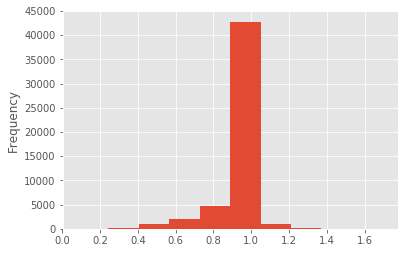

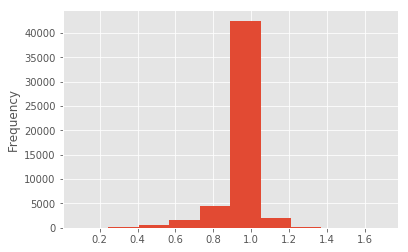

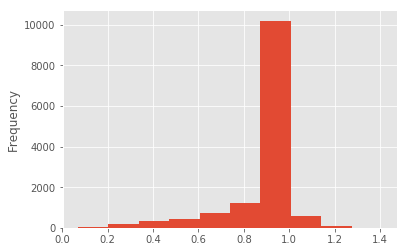

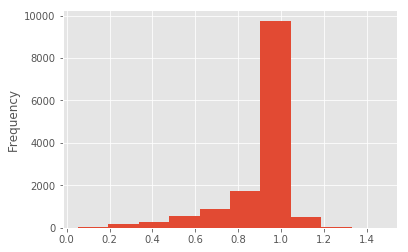

In [25]:
ax = same_name_df['qper_x'].plot(kind='hist')
plt.figure()
ax = same_name_df['qper_y'].plot(kind='hist')
plt.figure()
ax = diff_name_df['qper_x'].plot(kind='hist')
plt.figure()
ax = diff_name_df['qper_y'].plot(kind='hist')

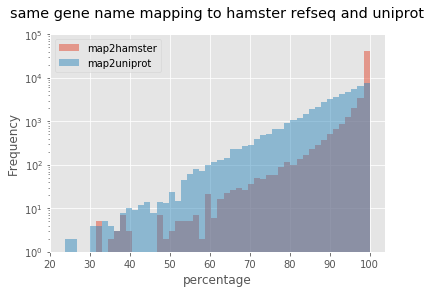

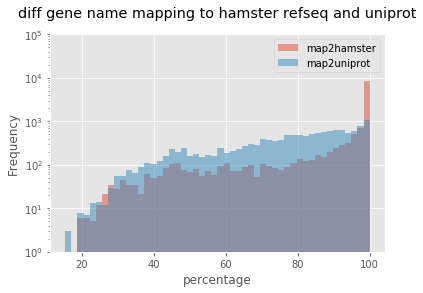

In [26]:
ax = same_name_df[['map2hamster','map2uniprot']].plot(kind='hist',bins=50,alpha=0.5,figsize=(6,4))
_ = ax.set_title('same gene name mapping '
                'to hamster refseq and uniprot')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('percentage')
_ = ax.set_ylim([1,100000])
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.savefig('/data/shangzhong/fig1.jpg',dpi=600)
ax = diff_name_df[['map2hamster','map2uniprot']].plot(kind='hist',bins=50,alpha=0.5,figsize=(6,4))
_ = ax.set_title('diff gene name '
                 'mapping to hamster refseq and uniprot')
_ = ax.set_yscale('log')
_ = ax.set_xlabel('percentage')
_ = ax.set_ylim([1,100000])
ttl = ax.title
ttl.set_position([.5, 1.05])
plt.savefig('/data/shangzhong/fig2.jpg',dpi=600)

From the figure above, we can see that for transcripts that have the same gene name when mapping to hamster refseq and uniprot, the cut off for hamster refseq is 60%, for uniprot is 50%. So I will use these thresholds to categorize the confidence level of the transcripts.

In [27]:
same_name_abv_6050 = same_name_df.query('(map2hamster>=60 and map2uniprot>=50) and '
                        '(qper_x>=0.8 or sper_x>=0.8)').index.unique().tolist()
same_name_blw_6050 = list(set(same_name_df.index.unique())-set(same_name_abv_6050))
diff_name_abv_6050 = diff_name_df.query('(map2hamster>=60 and map2uniprot>=50) and '
                                       '(qper_x>=0.8 or sper_x>=0.8)').index.unique()
diff_name_blw_6050 = list(set(diff_name_df.index.unique())-set(diff_name_abv_6050))
print 'there are',len(same_name_abv_6050),'transcripts have same name above 6050 percent'
print 'there are',len(same_name_blw_6050),'transcripts have same name below 6050 percent'
print 'there are',len(diff_name_abv_6050),'transcripts have diff name above 6050 percent'
print 'there are',len(diff_name_blw_6050),'transcripts have diff name below 6050 percent'

there are 49084 transcripts have same name above 6050 percent
there are 2607 transcripts have same name below 6050 percent
there are 10260 transcripts have diff name above 6050 percent
there are 4129 transcripts have diff name below 6050 percent


there are 51532 transcripts have same name above 6050 percent
there are 159 transcripts have same name below 6050 percent
there are 11057 transcripts have diff name above 6050 percent
there are 3332 transcripts have diff name below 6050 percent

#### 5. Get long noncoding RNAs

In [28]:
map2hamrna_df = pd.read_csv(map2ham_rna,sep='\t',header=None,names=['qacc',
        'sacc','pident','length','mismatch','gapopen','qstart','qend','sstart','send',
        'evalue','qlen','slen'])
map2hamrna_df['qstart'] -= 1
map2hamrna_df['score'] = map2hamrna_df['length']*map2hamrna_df['pident']
map2hamrna_df['qlen_per'] = (map2hamrna_df['qend']-map2hamrna_df['qstart'])/map2hamrna_df['qlen']
map2hamrna_df = map2hamrna_df[map2hamrna_df['sacc'].str.startswith('XR_')]

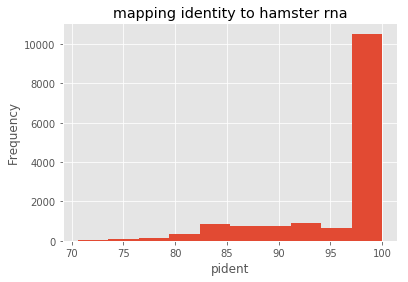

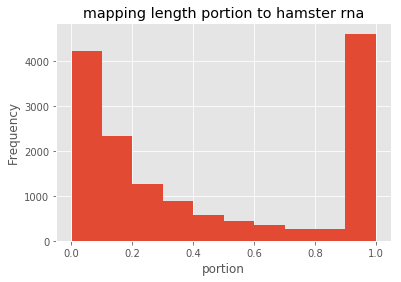

In [29]:
ax = map2hamrna_df['pident'].plot(kind='hist')
_ = ax.set_title('mapping identity to hamster rna')
_ = ax.set_xlabel('pident')
plt.figure()
ax = map2hamrna_df['qlen_per'].plot(kind='hist')
_ = ax.set_title('mapping length portion to hamster rna')
_ = ax.set_xlabel('portion')

In [30]:
idx = map2hamrna_df.groupby('qacc')['score'].transform(max)==map2hamrna_df['score']
map2hamrna_df=map2hamrna_df[idx]
map2hamrna_df = map2hamrna_df.query('pident>=0.6 & qlen_per>=0.7')
lncRNA = map2hamrna_df['qacc'].unique().tolist()
lncRNA = list(set(lncRNA)-set(pr_assms))
print 'there are',len(lncRNA),'assmblies map to',map2hamrna_df['sacc'].unique().size,'long non coding rnas'

there are 4640 assmblies map to 4661 long non coding rnas


In [31]:
# build dictionary {asmb_id:gename}
ham_only_assm_nm_dic = ham_uni_id[ham_uni_id['gnm_y'].isnull()]['gnm_x'].to_dict()
# uni_only_assm_nm_dic = ham_uni_id[ham_uni_id['gnm_x'].isnull()]['gnm_y'].to_dict()
# change the key name to assmblies id
assm_gnm_dic = ham_uni_id['gnm_y'].to_dict()
for key in assm_gnm_dic.keys():
    assm_gnm_dic[key.split('.')[0]] = assm_gnm_dic.pop(key)
for key,v in ham_only_assm_nm_dic.iteritems():
    assm_gnm_dic[key.split('.')[0]] = v

In [32]:
rest_assms = set(pasa_pos_dic.keys())-set(lncRNA)- set(pr_assms)

#### 6. Generate gff file
store all the exon and cds into one dictionary

In [32]:
def prepare_gff(assms,all_rna_dic,pasa_pos_dic,trans_pr_pos_dic,cs,feature='mRNA'):
    '''
    feature: lncRNA or mRNA
    cs: confidence score
    '''
    for assm in assms:
        rnaid = assm.split('.')[0]
        gid = 'gene_'+assm_geneclust_dic[rnaid]
        try:
            gnm = assm_gnm_dic[rnaid]
        except:
            gnm = gid
        #-------------- get transcript positions
        rna_pos = pasa_pos_dic[rnaid]
        rna_chr = rna_pos[0][:-1]
        rna_str = rna_pos[0][-1]
        if rna_str == '+':
            tr_pos = sorted(rna_pos[1:],key=lambda x:x[0])
        else:
            tr_pos = sorted(rna_pos[1:],key=lambda x:x[0],reverse=True)
        # add mRNA and exon lines
        rna_s = min(tr_pos,key=lambda x:x[0])[0]
        rna_e = max(tr_pos,key=lambda x:x[1])[1]
        anno = 'ID={r};Parent={gid};gene_id={gid};Name={gnm};transcript_id={r};cs={c}'.format(
                        r=rnaid,gid=gid,gnm=gnm,c=str(cs))
        item = [rna_chr,'merge',feature,str(rna_s),str(rna_e),'.',rna_str,'.',anno]
        all_rna_dic[rnaid]=[item]
        n = 0
        for r in tr_pos:
            n +=1
            anno='ID={r}.exon{n};Parent={r};gene_id={gid};Name={gnm};transcript_id={r}'.format(
                        r=rnaid,n=str(n),gid=gid,gnm=gnm)
            item = [rna_chr,'merge','exon',str(r[0]),str(r[1]),'.',rna_str,'.',anno]
            all_rna_dic[rnaid].append(item)
        #---------------- get protein position
        try:
            pro_pos = trans_pr_pos_dic[assm]
            pro_chr = pro_pos[0][:-1]
            pro_str = pro_pos[0][-1]
            if pro_str == '+':
                pr_pos = sorted(pro_pos[1:],key=lambda x:x[0])
            else:
                pr_pos = sorted(pro_pos[1:],key=lambda x:x[0],reverse=True)
            if pro_pos[0] != rna_pos[0]:
                assert False,rnaid+' rna and protein sequence is not consistent on chr or str'
            n = 0
            for p in pr_pos:
                n +=1
                anno='ID={r}.cds{n};Parent={r};gene_id={gid};Name={gnm};protein_id={r}'.format(
                r=rnaid,n=str(n),gid=gid,gnm=gnm)
                item = [rna_chr,'merge','CDS',str(p[0]),str(p[1]),'.',rna_str,'.',anno]
                all_rna_dic[rnaid].append(item)
        except:
            print assm,'predicted protein not in transdecoder genome gff3 file'
            pass
    return all_rna_dic

In transdecoder genome gff file it has proteins for 66930 transcripts, but in pep file it has 71831.
There are 22493 transcripts don't have protein sequence in transdecoder genome gff file. Possible reason is that the predicted protein doesn't start with M, and some of them are lncRNA.

In [ ]:
rna_all_dic = {}
rna_all_dic = prepare_gff(same_name_abv_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,1)
rna_all_dic = prepare_gff(same_name_blw_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,3)
rna_all_dic = prepare_gff(diff_name_abv_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,2)
rna_all_dic = prepare_gff(diff_name_blw_6050,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,4)
rna_all_dic = prepare_gff(lncRNA,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,1,'lncRNA')
rna_all_dic = prepare_gff(rest_assms,rna_all_dic,pasa_pos_dic,trans_pr_pos_dic,5)

In [37]:
# output all transcripts in gff format
assem_gff_fn = path+'/01_merge.gff3'
if not os.path.exists(assem_gff_fn):
    with open(assem_gff_fn,'w') as out:
        for k in natsorted(rna_all_dic.keys()):
            for i in rna_all_dic[k]:
                out.write('\t'.join(i)+'\n')

In [38]:
def get_gene_rna_dic(assem_gff_fn):
    gene_rna_dic = {}  # {geneid:[all rnas]}
    with open(assem_gff_fn,) as in_f:
        for line in in_f:
            item = line.strip().split('\t')
            if item[2] in ['mRNA','lncRNA']:
                rnaid = re.search('(?<=ID=).+?(?=;)',item[8]).group(0)
                chrom = item[0]
                strand = item[6]
                geneid = re.search('(?<=gene_id=).+?(?=;)',item[8]).group(0)
                gename = re.search('(?<=Name=).+?(?=;|$)',item[8]).group(0)
                if geneid in gene_rna_dic:
                    gene_rna_dic[geneid].append([chrom,rnaid,strand,gename,[int(item[3]),int(item[4])]])
                else:
                    gene_rna_dic[geneid] = [[chrom,rnaid,strand,gename,[int(item[3]),int(item[4])]]]
    return gene_rna_dic
gene_rna_dic = get_gene_rna_dic(assem_gff_fn)        

In [39]:
n = 0
for k,v in gene_rna_dic.iteritems():
    v = sorted(v,key=lambda x: (x[0],x[4][0]))
    strands = [s[3] for s in v]
    if len(set(strands)) > 1:
        n += 1
print 'among the',len(gene_rna_dic),'gene clusters, there are',n,'clusters are splited into \
       multiple groups'

among the 30679 gene clusters, there are 3407 clusters are splited into        multiple groups


In [40]:
# add gene line in gff
def add_gene_line(merge_gene_fn):
    with open(merge_gene_fn,'w') as out_f:
        for gene,rnas in gene_rna_dic.iteritems():
            rnas = sorted(rnas,key=lambda x: (x[0],x[4][0]))
            # get the list of number having the same length with rnas, indicating 
            # whether to write the gene batch line. stores in gene_batch
            n = 0
            gene_batch = []
            gene_pos = {}  # {batch#:[start,end]}
            pre_chrom = ''
            pre_name = ''
            pre_start = pre_end = 0
            for rna in rnas: # [chrom,asmbl_id,[start,end]]
                rna_s = rna[4][0]
                rna_e = rna[4][1]
                if rna[0] != pre_chrom or rna[3] != pre_name:
                    n += 1
                    gene_batch.append(n)
                    gene_pos[n] = [rna_s,rna_e]
                else:
                    if rna_s > pre_end:
                        n += 1
                        gene_batch.append(n)
                        gene_pos[n] = [rna_s,rna_e]
                    else:
                        gene_batch.append(n)
                        gene_pos[n] = [min(rna_s,gene_pos[n][0]),max(rna_e,gene_pos[n][1])]
                pre_start = rna_s
                pre_end = rna_e
                pre_chrom = rna[0]
                pre_name = rna[3]
            pre_b = 0
            if len(set(gene_batch)) > 1:
                for b,rna in zip(gene_batch,rnas):
                    if b != pre_b:
                        anno='ID={g}_{b};gene_id={g}_{b};Name={name}'.format(g=gene,b=str(b),name=rna[3])
                        out_f.write('\t'.join([rna[0],'merge','gene',str(gene_pos[b][0]),
                                            str(gene_pos[b][1]),'.',rna[2],'.',anno])+'\n')
                        rna_all_info = rna_all_dic[rna[1]]
                        for rna_item in rna_all_info:
                            if rna_item[2] in ['mRNA','lncRNA']:
                                rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                            rna_item[8]=re.sub('(?<=gene_id=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                            out_f.write('\t'.join(rna_item)+'\n')
                        pre_b = b
                    else:
                        rna_all_info = rna_all_dic[rna[1]]
                        for rna_item in rna_all_info:
                            if rna_item[2] in ['mRNA','lncRNA']:
                                rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                            rna_item[8]=re.sub('(?<=gene_id=).+?(?=;)',gene+'_'+str(b),rna_item[8])
                            out_f.write('\t'.join(rna_item)+'\n')
            else:
                anno='ID={g};gene_id={g};Name={name}'.format(g=gene,name=rna[3])
                out_f.write('\t'.join([rnas[0][0],'merge','gene',str(gene_pos[1][0]),
                                    str(gene_pos[1][1]),'.',rna[2],'.',anno])+'\n')
                for rna in rnas:
                    rna_all_info = rna_all_dic[rna[1]]
                    for rna_item in rna_all_info:
    #                     if rna_item[2] in ['mRNA','lncRNA']:
    #                         rna_item[8]=re.sub('(?<=Parent=).+?(?=;)',gene,rna_item[8])
                        out_f.write('\t'.join(rna_item)+'\n')
merge_gene_fn = path + '/02_merge_gene.gff3'
if not os.path.exists(merge_gene_fn):
    add_gene_line(merge_gene_fn)

In [41]:
# add frame information for CDS
def add_frame(merge_gene_fn,draft_gff_fn):
    with open(draft_gff_fn,'w') as out, open(merge_gene_fn) as inf:
        pre_pr = ''
        for line in inf:
            if line.startswith('#'):
                out.write(line)
            else:
                item = line.split('\t')
                if item[2] == 'CDS':
                    pr = re.search('(?<=protein_id=).+?(?=$|;)',item[8]).group(0)
                    if pr != pre_pr:
                        pre_pr = pr
                        item[7] = '0'
                        n = abs(int(item[3])-int(item[4]))+1
                    else:
                        item[7] = str(n % 3)
                        n += abs(int(item[3])-int(item[4]))+1
                    out.write('\t'.join(item))
                else:
                    out.write(line)
draft_gff_fn = path+'/03_pasa_stringtie.gff3'
add_frame(merge_gene_fn,draft_gff_fn)

In [ ]:
# generate pr fa file
pr_fa = path + '/gff_pr.fa'
if not os.path.exists(pr_fa):
    cmd = ('gffread {gff} -g {ref_fa} -y {pr_fa}').format(
        gff=draft_gff_fn,ref_fa=ref_fa,pr_fa=pr_fa)
    sarge.run(cmd)

# remove stop codon
with open(path+'/03_pasa_stringtie_pr.fa','w') as out:
    for record in SeqIO.parse(pr_fa,'fasta'):
        if record.seq[-1]=='.':
            record.seq = record.seq[:-1]
        SeqIO.write(record,out,'fasta')
os.remove(pr_fa)

gffread /data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/03_pasa_stringtie.gff3 -g /data/genome/hamster/picr_old/picr.fa -y /data/shangzhong/Picr_assembly/Annotation/PASA/pasa_stringtie/gff_pr.fa
